### 🤖 LLM and AI Agent Development Courses  
**✨ All courses available for just ₹399 INR / $9.99 USD ✨**

| Course | Description | Enroll |
|--------|-------------|---------|
| **🎯 Master OpenAI Agent Builder** | Build and deploy AI agents visually using OpenAI Agent Builder, ChatKit, RAG, Chatbot, AI Assistant with MCP, AWS, RDS MySQL | [Enroll Now](https://kgptalkie.com/agent-builder) |
| **🔥 MCP Mastery** | Build MCP servers & clients with Python, Streamlit, ChromaDB, LangChain, LangGraph agents, and Ollama integrations | [Enroll Now](https://kgptalkie.com/mcp) |
| **📊 Private Agentic RAG with LangChain** | Step-by-Step Guide to RAG with LangChain v1, LangGraph, and Ollama (Qwen3, Gemma3, DeepSeek-R1, LLAMA, FAISS) | [Enroll Now](https://kgptalkie.com/agentic-rag) |
| **🔧 Master LangGraph and LangChain** | Agentic RAG and Chatbot, AI Agent with LangChain v1, Qwen3, Gemma3, DeepSeek-R1, LLAMA 3.2, FAISS Vector Database | [Enroll Now](https://kgptalkie.com/langgraph) |
| **⚡ Master Langchain and Ollama** | Master Langchain v1, Local LLM Projects with Ollama, Qwen3, Gemma3, DeepSeek-R1, LLAMA 3.2, Complete Integration Guide | [Enroll Now](https://kgptalkie.com/langchain) |
| **🔬 Fine Tuning LLM** | Learn transformer architecture fundamentals and fine-tune LLMs with custom datasets | [Enroll Now](https://kgptalkie.com/fine-tuning-llm) |

---

### 🌐 Join the Community & Stay Connected

- 🔗 **Join the Discord Community:** https://discord.gg/RFjwbkNa  
- 📺 **Subscribe on YouTube (63K+ learners):** http://www.youtube.com/@KGPTalkie

---


## SQL Agent with Dedicated Tools using create_agent
**Key Features:**
- Agent-based SQL query generation with autonomous tool usage
- SQLite database integration with employees database
- Safety validation system to prevent destructive SQL operations
- Automatic error detection and query correction capabilities
- Interactive chat interface for natural language database queries

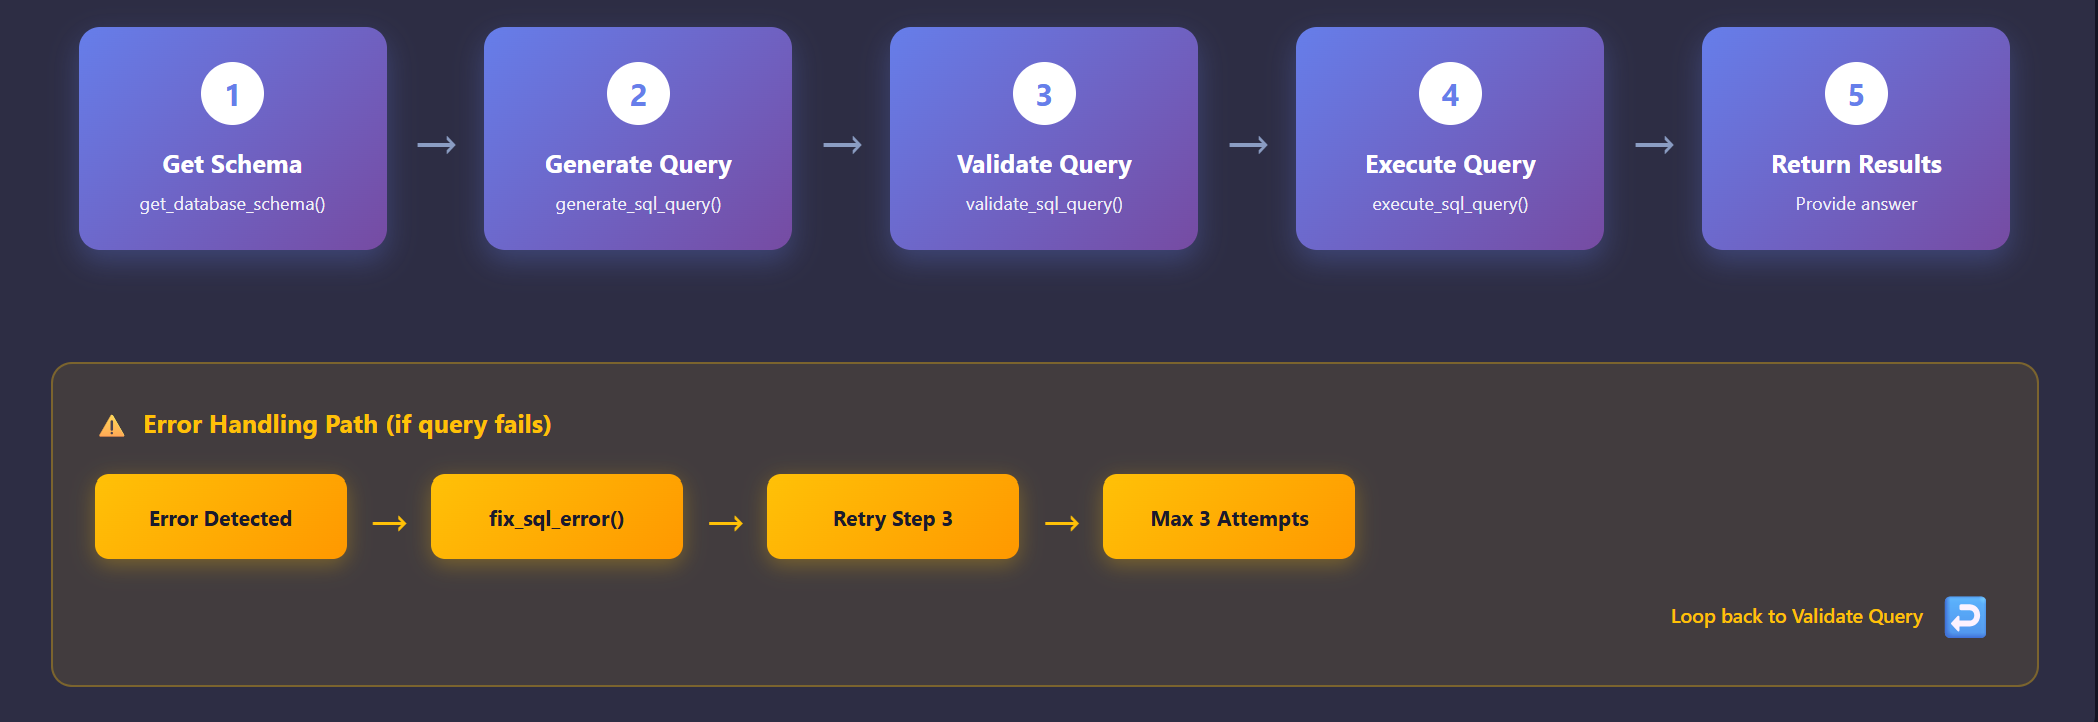

In [1]:
# https://github.com/fracpete/employees-db-sqlite

In [2]:
import re
from dotenv import load_dotenv
load_dotenv()

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.utilities import SQLDatabase
from langchain_core.tools import tool
from langchain.agents import create_agent

In [3]:
db = SQLDatabase.from_uri("sqlite:///db/employees.db")

tables = db.get_usable_table_names()
print(f"Connected to database with {len(tables)} tables: {', '.join(tables)}")

SCHEMA = db.get_table_info()

Connected to database with 6 tables: departments, dept_emp, dept_manager, employees, salaries, titles


In [4]:
tables

['departments', 'dept_emp', 'dept_manager', 'employees', 'salaries', 'titles']

In [5]:
db.run("SELECT name FROM sqlite_master WHERE type='table';")

"[('departments',), ('dept_emp',), ('dept_manager',), ('employees',), ('salaries',), ('titles',)]"

In [6]:
db.run("select count(*) from employees")

'[(300024,)]'

In [7]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

response = llm.invoke("Hello, how are you?")
print(response.content)

Hello! I'm functioning perfectly and ready to assist you.

How are you doing today?


In [8]:
@tool
def get_database_schema(table_name: str = None) -> str:
    """Get database schema information for SQL query generation."""
    if table_name:
        tables = db.get_usable_table_names()
        if table_name.lower() in [t.lower() for t in tables]:
            return db.get_table_info([table_name])
        return f"Error: Table '{table_name}' not found. Available: {', '.join(tables)}"
    return SCHEMA

In [9]:
result = get_database_schema.invoke({'table_name': 'departments'})
print(result)


CREATE TABLE departments (
	dept_no CHAR(4) NOT NULL, 
	dept_name VARCHAR(40) NOT NULL, 
	PRIMARY KEY (dept_no), 
	UNIQUE (dept_name)
)

/*
3 rows from departments table:
dept_no	dept_name
d009	Customer Service
d005	Development
d002	Finance
*/


In [10]:
@tool
def generate_sql_query(question: str, schema_info: str = None) -> str:
    """Generate SQL SELECT query from natural language question."""
    schema_to_use = schema_info if schema_info else SCHEMA
    
    prompt = f"""Based on this database schema:
{schema_to_use}

Generate a SQL query to answer: {question}

Rules:
- Use only SELECT statements
- Include only existing columns and tables
- Add appropriate WHERE, GROUP BY, ORDER BY clauses as needed
- Limit results to 10 rows unless specified
- Use proper SQLite syntax

Return only the SQL query."""
    
    response = llm.invoke(prompt)
    return response.content.strip()

In [11]:
result = generate_sql_query.invoke({"question": "what is maximum salary in employees"})
print(result)

```sqlite
SELECT
  MAX(salary)
FROM salaries;
```


In [12]:
db.run("SELECT MAX(salary) FROM salaries;")

'[(158220,)]'

Examples Query:

```sql
SELECT MAX(salary) FROM salaries;
```

In [13]:
@tool
def execute_sql_query(query: str) -> str:
    """Execute validated SQL query and return results."""
    clean_query = query.strip()
    if clean_query.startswith("Valid: "):
        clean_query = clean_query[7:]
    
    clean_query = re.sub(r'```sql\s*', '', clean_query, flags=re.IGNORECASE)
    clean_query = re.sub(r'```\s*', '', clean_query).strip().rstrip(";")
    
    result = db.run(clean_query)
    return f"Query Results:\n{result}" if result else "No results"

In [14]:
execute_sql_query.invoke({"query": "SELECT MAX(salary) FROM salaries;"})

'Query Results:\n[(158220,)]'

In [15]:
SQL_SYSTEM_PROMPT = f"""You are an expert SQL analyst working with an employees database.

Database Schema:
{SCHEMA}

Workflow:
1. Use get_database_schema to understand tables and columns
2. Use generate_sql_query to create SQL based on the question
3. Use execute_sql_query to run the query
4. Provide clear answer based on results

Rules:
- Follow the workflow step by step
- Be precise with table and column names
- Provide clear, informative answers"""

In [16]:
tools = [
    get_database_schema,
    generate_sql_query,
    execute_sql_query
]

sql_agent = create_agent(llm, tools, system_prompt=SQL_SYSTEM_PROMPT)

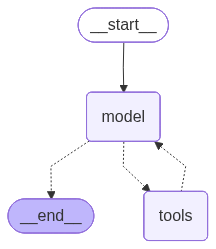

In [17]:
sql_agent

In [20]:
def ask_sql(question: str):
    """Ask the SQL agent a question."""
    print(f"\nQuestion: {question}\n{'='*60}")
    
    for event in sql_agent.stream({"messages": question}, stream_mode="values"):
        msg = event["messages"][-1]
        
        if hasattr(msg, 'tool_calls') and msg.tool_calls:
            for tc in msg.tool_calls:
                print(f"Tool: {tc['name']}")
        
        elif hasattr(msg, 'content') and msg.content:
            print(f"\n{msg.text}")

In [21]:
ask_sql("What is the average salary of employees in the Sales department?")


Question: What is the average salary of employees in the Sales department?

What is the average salary of employees in the Sales department?
Tool: generate_sql_query

```sql
SELECT
  AVG(T3.salary)
FROM departments AS T1
INNER JOIN dept_emp AS T2
  ON T1.dept_no = T2.dept_no
INNER JOIN salaries AS T3
  ON T2.emp_no = T3.emp_no
WHERE
  T1.dept_name = 'Sales' AND T3.from_date <= T2.to_date AND T3.to_date >= T2.from_date;
```
Tool: execute_sql_query

Query Results:
[(80638.96079606736,)]

The average salary of employees in the Sales department is 80638.96.
